<a href="https://colab.research.google.com/github/soumyadip1995/language-models/blob/main/Notebook/Multi_head_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
words = open('/content/text.txt', 'r').read().split()
words[:20]

['So',
 'Ray',
 'J',
 'went',
 'straight',
 'to',
 'the',
 'radio',
 'station',
 'The',
 'very',
 'next',
 'day,',
 '"Hey',
 'Fab,',
 "I'ma",
 'kill',
 'you!"',
 'Lyrics',
 "comin'"]

In [2]:
import torch
from torch import nn

chars = sorted(list(set(words)))
string2integer = {ch: i for i, ch in enumerate(chars)}
print(string2integer)

integer2string = {i:ch for ch,i in string2integer.items()}
encode = lambda s: [string2integer[c] for c in s]
print(encode)

decode = lambda l: ''.join([integer2string[i] for i in l])
print(decode)

data = torch.tensor(encode(words), dtype = torch.long)
print(data)
data.size()

{'"': 0, '"Hey': 1, '"It\'s': 2, '"Lose': 3, '"Oh,': 4, "'Cause": 5, "'cause": 6, "'em": 7, '(J.J.': 8, 'Doc': 9, 'Fab,': 10, 'Fad)': 11, 'For': 12, 'How': 13, 'I': 14, "I'm": 15, "I'ma": 16, 'Innovative': 17, 'J': 18, 'Lyrics': 19, 'Never': 20, 'Ray': 21, 'So': 22, 'The': 23, 'Throw': 24, 'Uh,': 25, 'Well,': 26, 'What': 27, 'With': 28, 'You': 29, 'Yourself"': 30, 'a': 31, 'and': 32, 'anything': 33, 'are': 34, "assumin'": 35, 'at': 36, 'audience': 37, 'be': 38, 'can': 39, 'celebrating': 40, "comin'": 41, 'confuse': 42, 'day': 43, 'day,': 44, 'demonstrating': 45, 'devastating,': 46, 'do': 47, 'dooma-lumma,': 48, 'elevating': 49, 'elevator': 50, 'ever': 51, 'fading,': 52, 'feeling': 53, 'fell': 54, 'forever': 55, 'found': 56, 'fuse': 57, 'get': 58, 'give': 59, 'glue': 60, 'gotta': 61, 'haters': 62, "he's": 63, 'hella': 64, 'hip-hop,': 65, 'human': 66, 'is': 67, 'it': 68, "it'll": 69, "it's": 70, 'jealous,': 71, 'kill': 72, 'know': 73, 'levitating': 74, 'like': 75, 'lose': 76, 'made': 77,

torch.Size([172])

In [3]:
## block_size and batch size has been changed from 64 and 512 to 32 and 128
block_size = 32
batch_size = 128
ix = torch.randint(len(data) - block_size, (batch_size,))
ix.size()


torch.Size([128])

In [4]:
## hidden dimensionality has been changed from 512 to 128.

vocab_size = len(chars)

d_k = 128

token_emb = nn.Embedding(vocab_size, d_k)
token_emb

Embedding(125, 128)

In [5]:
x = torch.stack([data[i:i + block_size] for i in ix])
x.shape
# d = x.float()
# d


torch.Size([128, 32])

In [6]:
input_embeds = token_emb(x)
input_embeds.size()

torch.Size([128, 32, 128])

In [ ]:

# p = x.transpose(-2, 1)
# p.size()

In [7]:
import math
import numpy as np 
import torch.nn.functional  as F
import torch
from math import sqrt


def scaled_dot_product(query, key, value):
  dim_k = query.size(-1)
  scores = torch.bmm(query, key.transpose(-2, -1)) / sqrt(dim_k)
  weights = F.softmax(scores, dim = -1)
  return torch.bmm(weights, value)
  


In [8]:
# size = 64
# dim_k = 512
# key = torch.randn(batch_size, size, dim_k)
# value = torch.randn(batch_size, size, dim_k) 
# query = torch.randn(batch_size, size, dim_k)

key = input_embeds
query = input_embeds
value = input_embeds

sdp = scaled_dot_product(query, key, value)
sdp.size()

torch.Size([128, 32, 128])

In [ ]:
# import torch
# chars = sorted(list(set(words)))
# # print(chars)
# size = len(chars) # sequence length
# # print(size)

# torch.manual_seed(1337)



# key , value, query = input_embeds

# # key = torch.randn(batch_size, size, dim_k)
# # value = torch.randn(batch_size, size, dim_k) 
# # query = torch.randn(batch_size, size, dim_k)



# sdp = scaled_dot_product_attention(query, key, value)
# sdp.size()

In [9]:
x
# x.size()

tensor([[ 77,  88,  97,  ...,  82,  37,  31],
        [ 33,  29,  98,  ...,  70,  74,  20],
        [ 33,  29,  98,  ...,  70,  74,  20],
        ...,
        [108,  33,  29,  ...,  75,  70,  74],
        [ 84,   4,  63,  ..., 114,  57,  68],
        [ 35,  15,  31,  ...,  89,  88,  80]])

In [10]:
## A single attention head

class AttentionHead(nn.Module):
  def __init__(self, embedded_dim, head_dim):
    super().__init__()
    self.q = nn.Linear(embedded_dim, head_dim)
    self.k = nn.Linear(embedded_dim,  head_dim)
    self.v = nn.Linear(embedded_dim,  head_dim)

  def forward(self, x):
    attention_outputs = scaled_dot_product(self.q(x), self.k(x), self.v(x))
    

    return attention_outputs
    

### Multi headed attention

Having many heads allows the model to focus on different parts of the sentences. The softmax on one head tends to focus on one aspect of similarity. For example subject verb interaction.

In [11]:
# embedding_dim = embedding dimensions
# num_heads  = number of heads 


class MultiHeadAttention(nn.Module):
  def __init__(self, embedded_dim, num_heads):
    super().__init__()
    self.embedded_dim = embedded_dim
    self.num_heads = num_heads
    head_dim = embedded_dim // num_heads 

    self.heads = nn.ModuleList([AttentionHead(embedded_dim, head_dim) for _ in range(num_heads)])
    self.output_linear = nn.Linear(embedded_dim, embedded_dim)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim = -1)
    
    out = self.output_linear(out)

    return out

In [12]:
multihead_attention = MultiHeadAttention(128, 8)
# multihead_attention

attention_outputs =  multihead_attention(input_embeds)
attention_outputs.size()

torch.Size([128, 32, 128])

###### ⬆ A discrepancy in shape is occuring in the above snippet. Will try to fix it.

Note:-  Discrepancy has been solved.

An alternative implementation of Multi headed attention has also been provided.





In [ ]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        d_k = K.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k).float())
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        weights = nn.Softmax(dim=-1)(scores)
        output = torch.matmul(weights, V)
        return output
        
    def forward(self, Q, K, V, mask=None):
        
        
        # Apply linear transformation to Q, K, and V
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)
        
        # Split into multiple heads
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k)
        K = K.view(batch_size, -1, self.num_heads, self.d_k)
        V = V.view(batch_size, -1, self.num_heads, self.d_k)
        
        # Transpose to prepare for matrix multiplication
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # Compute attention scores and weights
        output = self.scaled_dot_product_attention(Q, K, V, mask=mask)
        
        # Concatenate the outputs of the multiple heads
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.W_o(output)
        
        return output



In [ ]:
d_model = 512
num_heads = 8

import torch
chars = sorted(list(set(words)))
# print(chars)
seq_len = len(chars) # sequence length



Q = input_embeds
K = input_embeds
V = input_embeds

# Q = torch.randn(batch_size, seq_len, d_model)
# K = torch.randn(batch_size, seq_len, d_model)
# V = torch.randn(batch_size, seq_len, d_model)

# Create an instance of the multi-head attention model
multihead_attn = MultiHeadAttention(d_model, num_heads)

# Pass the input tensors through the model
output = multihead_attn(Q, K, V)

# The output tensor has shape (batch_size, seq_len, d_model)
print(output.shape)


torch.Size([512, 64, 512])


This one works, for now.

In [ ]:
# embedding_dim = embedding dimensions
# num_heads  = number of heads 


class MultiHeadAttention(nn.Module):
  def __init__(self, embedded_dim, num_heads):
    super().__init__()
    self.embedded_dim = embedded_dim
    self.num_heads = num_heads
    head_dim = embedded_dim // num_heads 

    self.heads = nn.ModuleList([AttentionHead(embedded_dim, head_dim) for _ in range(num_heads)])
    self.output_linear = nn.Linear(embedded_dim, embedded_dim)

  def forward(self, p):
    out = torch.cat([h(p) for h in self.heads], dim = -1)
    
    out = self.output_linear(out)

    return out


In [ ]:
multihead_attention = MultiHeadAttention(embedded_dim = 512, num_heads = 8)
multihead_attention

MultiHeadAttention(
  (heads): ModuleList(
    (0): AttentionHead(
      (q): Linear(in_features=512, out_features=64, bias=False)
      (k): Linear(in_features=512, out_features=64, bias=False)
      (v): Linear(in_features=512, out_features=64, bias=False)
    )
    (1): AttentionHead(
      (q): Linear(in_features=512, out_features=64, bias=False)
      (k): Linear(in_features=512, out_features=64, bias=False)
      (v): Linear(in_features=512, out_features=64, bias=False)
    )
    (2): AttentionHead(
      (q): Linear(in_features=512, out_features=64, bias=False)
      (k): Linear(in_features=512, out_features=64, bias=False)
      (v): Linear(in_features=512, out_features=64, bias=False)
    )
    (3): AttentionHead(
      (q): Linear(in_features=512, out_features=64, bias=False)
      (k): Linear(in_features=512, out_features=64, bias=False)
      (v): Linear(in_features=512, out_features=64, bias=False)
    )
    (4): AttentionHead(
      (q): Linear(in_features=512, out_featur

In [ ]:
#### Single headed attention

import torch
import torch.nn as nn

class SingleAttention(nn.Module):
    def __init__(self, embedded_dim):
        super(SingleAttention, self).__init__()
        self.embedded_dim = embedded_dim
        
        self.W_q = nn.Linear(embedded_dim, embedded_dim)
        self.W_k = nn.Linear(embedded_dim, embedded_dim)
        self.W_v = nn.Linear(embedded_dim, embedded_dim)
        self.W_o = nn.Linear(embedded_dim, embedded_dim)
        
    def forward(self, Q, K, V, mask=None):
        
        
        # Apply linear transformation to Q, K, and V
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)
        
        # Compute attention scores and weights
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.embedded_dim).float())
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        weights = nn.Softmax(dim=-1)(scores)
        
        # Apply attention weights to values
        output = torch.matmul(weights, V)
        output = self.W_o(output)
        
        return output


In [ ]:



import torch
chars = sorted(list(set(words)))
# print(chars)
seq_len = len(chars) # sequence length
embedded_dim = 512


# Create some dummy input tensors
Q = torch.randn(batch_size, seq_len, embedded_dim)

K = torch.randn(batch_size, seq_len, embedded_dim)
V = torch.randn(batch_size, seq_len, embedded_dim)

# Create an instance of the single attention model
single_attn = SingleAttention(embedded_dim)

# Pass the input tensors through the model
output = single_attn(Q, K, V)
output.shape


torch.Size([512, 125, 512])

In [ ]:
!pip install torchshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Visualize the attention

Create an attention map if possible.

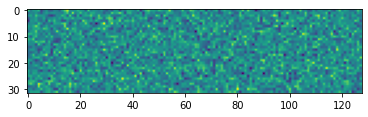

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 

model = MultiHeadAttention(128, 8)
# model

attention_outputs = model(input_embeds)

z = torch.randn(attention_outputs.shape)
# z
plt.imshow(z[0, :, :])

# vis = torch.rand(m.shape).permute(0, 2, 1)[:, :, -1]
# plt.imshow(vis)


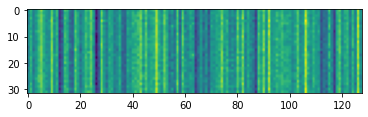

In [ ]:
input = attention_outputs.detach().numpy().copy()
plt.imshow(input[1, :, :])
# plt.plot(input[0, :, :])

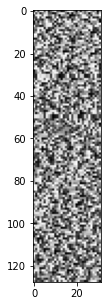

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(x.detach(), cmap='gray')

/usr/local/lib/python3.9/dist-packages/torchshow/visualization.py:378: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


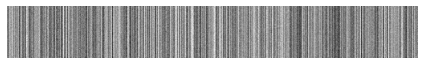

In [ ]:
import torchshow as ts

ts.show(attention_outputs[0, :, :])

In [13]:
x

tensor([[ 77,  88,  97,  ...,  82,  37,  31],
        [ 33,  29,  98,  ...,  70,  74,  20],
        [ 33,  29,  98,  ...,  70,  74,  20],
        ...,
        [108,  33,  29,  ...,  75,  70,  74],
        [ 84,   4,  63,  ..., 114,  57,  68],
        [ 35,  15,  31,  ...,  89,  88,  80]])

#### Feedforward layer



In [14]:
# from karpathy , partially
dropout = 0.2

class FeedForward(nn.Module):
  def __init__(self, embedded_dim):
    super(FeedForward, self).__init__()
    self.net = nn.Sequential(nn.Linear(embedded_dim, 4 * embedded_dim),
    nn.Linear(4 * embedded_dim, embedded_dim),
    nn.GELU(),
    nn.Dropout(dropout))

  def forward(self, x):
    return self.net(x)



In [15]:
feed_forward = FeedForward(embedded_dim = 128)
# feed_forward
ff_outputs = feed_forward(attention_outputs)
ff_outputs.size()

torch.Size([128, 32, 128])

#### Adding Layer Normalization

In [16]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embedded_dim, num_heads):
    super(TransformerEncoderLayer, self).__init__()
    self.attention = MultiHeadAttention(embedded_dim,  num_heads)
    self.feed_forward = FeedForward(embedded_dim)
    self.layer_norm_1 = nn.LayerNorm(embedded_dim)
    self.layer_norm_2 = nn.LayerNorm(embedded_dim)

  def forward(self, x):
    
    x = x + self.attention(self.layer_norm_1(x))
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x



In [17]:
encoder_layer = TransformerEncoderLayer(128, 8)
encoder_layer(input_embeds).size()



torch.Size([128, 32, 128])

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# y = torch.randn(encoder_layer(input_embeds).size())
# plt.imshow(y[2, :, :])

In [ ]:
data.size(-1)

172

In [ ]:
seq_length = x.size(-1)
position_ids = torch.arange(seq_length, dtype = torch.long).unsqueeze(0)
position_ids

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63]])

In [ ]:
### Positional embeddings

In [18]:
import torch
import torch.nn as nn

class Embeddings(nn.Module):
  def __init__(self, embedded_dim, d_k):
    super(Embeddings, self).__init__()
    self.token = nn.Embedding(embedded_dim, d_k)
    self.position = nn.Embedding(embedded_dim, d_k)
    self.layer_norm = nn.LayerNorm(d_k, eps = 1e-12)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, x):
    seq_length = x.size(-1)
    position_ids = torch.arange(seq_length, dtype = torch.long).unsqueeze(0)
    token = self.token(x)
    position = self.position(position_ids)
    embeddings = token + position
    embeddings = self.layer_norm(embeddings)
    embeddings = self.dropout(embeddings)
    return embeddings

  


In [19]:
Embedding_layer = Embeddings(128, d_k)
# Embedding_layer
# torch.tensor(b_input_ids).to(device).long()
layer = Embedding_layer(x)
layer.size()

torch.Size([128, 32, 128])

In [20]:
class TransformerEncoder(nn.Module):
  def __init__(self, embedded_dim, num_heads, d_k):
    super(TransformerEncoder, self).__init__()
    self.embeddings = Embeddings(embedded_dim, d_k)
    self.layers = nn.ModuleList([TransformerEncoderLayer(embedded_dim, num_heads) for _ in range(num_heads)])

  def forward(self, x):
    x = self.embeddings(x)
    for layer in self.layers:
      x = layer(x)
    return x




In [21]:
encoder = TransformerEncoder(128, 8, d_k)
l = encoder(x)
l.size()

torch.Size([128, 32, 128])

In [22]:
### inspired from pytorch decoder layer


class TransformerDecoderLayer(nn.Module):
  def __init__(self, embedded_dim, num_heads, layer_norm_eps: float = 1e-5, dropout = 0.2, norm_first: bool = False):
    super(TransformerDecoderLayer, self).__init__()
    self.self_attn = MultiHeadAttention(embedded_dim, num_heads)
    self.multihead_attn = MultiHeadAttention(embedded_dim, num_heads)
    # Implementation of Feedforward model
    self.linear1 = nn.Linear(embedded_dim, 4 * embedded_dim)
    self.dropout = nn.Dropout(dropout)
    self.linear2 = nn.Linear(4 * embedded_dim, embedded_dim)
    
    self.norm_first = norm_first
    self.norm1 = nn.LayerNorm(embedded_dim, eps=layer_norm_eps)
    self.norm2 = nn.LayerNorm(embedded_dim, eps=layer_norm_eps)
    self.norm3 = nn.LayerNorm(embedded_dim, eps=layer_norm_eps)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)

  def forward(self, x):
    if self.norm_first:
      x = x + self._sa_block(self.norm1(x))
      x = x + self._mha_block(self.norm2(x))
      x = x + self._ff_block(self.norm3(x))   
    else:

      x = self.norm1(x + self._sa_block(x))
      x = self.norm2(x + self._mha_block(x))
      x = self.norm3(x + self._ff_block(x))
      return x


  # self-attention block
  def _sa_block(self, x):
    x = self.self_attn(x)[0]
    return self.dropout1(x)

  # multihead attention block
  def _mha_block(self, x):
    x = self.multihead_attn(x)[0]
    return self.dropout2(x)
    
  # feed forward block
  def _ff_block(self, x):
    x = self.linear2(self.dropout(self.linear1(x)))
    return self.dropout3(x)


In [23]:
Decoder_layer = TransformerDecoderLayer(embedded_dim = 128, num_heads = 8)
lay = Decoder_layer(input_embeds)
lay.size()

torch.Size([128, 32, 128])

In [24]:
class TransformerDecoder(nn.Module):
  def __init__(self, embedded_dim, num_heads, d_k):
    super(TransformerDecoder, self).__init__()
    self.embeddings = Embeddings(embedded_dim, d_k)
    self.layers = nn.ModuleList([TransformerDecoderLayer(embedded_dim, num_heads) for _ in range(num_heads)])

  def forward(self, x):
    x = self.embeddings(x)
    for layer in self.layers:
      x = layer(x)
    return x


In [25]:
decoder = TransformerDecoder(128, 8, d_k)
z = decoder(x)
z.size()


torch.Size([128, 32, 128])

### Classification head

In [26]:
num_labels = 3
class SequenceClassification(nn.Module):
  def __init__(self, embedded_dim, num_heads, d_k):
    super().__init__()
    self.decoder = TransformerDecoder(embedded_dim, num_heads, d_k)
    self.dropout = nn.Dropout(p = 0.2)
    self.classifier = nn.Linear(embedded_dim, num_labels)


  def forward(self, x):
    x = self.decoder(x)[:, 0, :]
    x = self.dropout(x)
    x = self.classifier(x)
    return x


In [27]:
decoder_classifier = SequenceClassification(128, 8, d_k)
cl = decoder_classifier(x)
cl.size()

torch.Size([128, 3])



```
scaled-dot product attention
multi headed attention
feed forward layer
layer normalization(transformerencoderlayer)
positional embeddings
transformer encoder
transformer decoder
transformer decoder layer
classification head

```



#### putting it together

In [37]:
class Transformermodel(nn.Module):
  def __init__(self, embedded_dim, num_heads, d_k):
    super(Transformermodel, self).__init__()
    self.positional_embeddings = Embeddings(embedded_dim, d_k)
    self.transformer_encoder = TransformerEncoder(embedded_dim, num_heads, d_k)
    self.transformer_decoder = TransformerDecoder(embedded_dim, num_heads, d_k)
    self.layers1 = nn.ModuleList([TransformerDecoderLayer(embedded_dim, num_heads) for _ in range(num_heads)])
    self.layers2 = nn.ModuleList([TransformerEncoderLayer(embedded_dim, num_heads) for _ in range(num_heads)])

  def forward(self, x):
    x = self.positional_embeddings(x)
    for layers1 in self.layers1:
      x = layers1(x)
    for layers2 in self.layers2:
      x = layers2(x)
      return x

In [39]:


Transformer = Transformermodel(128, 8, d_k)
to = Transformer(x)
to.size()


torch.Size([128, 32, 128])